# ACCESS-OM2 1$^\circ$

This notebook documents our first attempt to run and analyse output from the ACCESS-OM2 Pre-release, implemented at 1°.


## Current Status


|** Run Name** | **Forcing** | ** Run ** | ** Status **|
|--------------|---------|-------------------------------------------------|-------------|
|1deg_jra55_ryf_spinup1 | JRA55 RYF9091| A short 10 year spinup with first pre-release code. Had bugs in runoff and salt fluxes.  <br> **IGNORE RUN: `rotate_winds=False`** | Aborted after 10 years.| 
|1deg_jra55_ryf_spinup2 | JRA55 RYF9091| Second attempt at 1° test. There are significant problems with salt and mass conservation in this run.| Stopped at 100 years.| 
|1deg_jra55_ryf_spinup3 | JRA55 RYF9091| Nic's initial 1° test. Still problems with salinity. Also, much of this run has problems with the ocean.nc files. | Stopped at 80 years.| 
|1deg_jra55_ryf_spinup4 | JRA55 RYF9091| Nic's improved 1° test. This simulation seems to have fixed the salt and volume imbalance, but is missing some diagnostics.| Up to 25 years.| 
|1deg_jra55_ryf_spinup5 | JRA55 RYF9091| Andy's 1° test. Unfortunately, this run reverted to the old ice_salt_concentration = 0.004 namelist setting, so melt and salt are unbalanced. | Stopped at year 40.| 
|1deg_jra55_ryf_spinup6 | JRA55 RYF9091| Andy's New & Improved 1° test. Again, this has a salt imbalance | Stopped after 24 years.| 
|1deg_jra55_ryf_spinup7 | JRA55 RYF9091| Same as spinup6, but with the Red Sea fix switched off. | Stopped after 28 years.| 
|1deg_jra55_ryf_spinup8 | JRA55 RYF9091| Same as spinup7, but update to Nic's new executable where we **think** the melt flux is now handled correctly. Turned Red Sea fix back on after year 4. This is running smoothly, but I can't get the timestep beyond 2160 (we are hoping for 3600).  | Stopped at year 184.| 
|1deg_jra55_ryf_spinup9 | JRA55 RYF9091| Same as spinup8 but with massless ice (max_ice_thickness=0.0). We hoped that this would improve model stability, but it didn't.  | 25 years in| 
|1deg_jra55_ryf8485_spinup1 | JRA55 RYF8485| Abhishek's first attempt at an RYF8485 spinup. Model was behaving itself but we started from the wrong initial condition, so stopped it. | Stopped after 30 years.| 
|1deg_jra55_ryf8485_spinup2 | JRA55 RYF8485| Abhishek's 2nd attempt at an RYF8485 spinup. Going well so far.| At 80 years.| 

### Notes
* Massless ice didn't fix our stability problems. We are still getting crashes in Bering Strait. Need to find our what is happening here.
* Fabio has suggested that we should increase teh SS restoring timescale to 60 days.
* Fabio has suggested we should use MDPPM over Sweby advection schemes.
* We should probably change the truncate_velocity to False.

**Last updated 17 September 2017**

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [2]:
client = cc.start_cluster()
client

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 45365:127.0.0.1:45365 vdi-n18.nci.org.au -l jm0634


Client Scheduler: tcp://127.0.0.1:46083 Dashboard: http://127.0.0.1:45365,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


In [3]:
cc.build_index()

Finding runs on disk...found 2590 run directories
Using database sqlite:////g/data1/v45/cosima-cookbook/cosima-cookbook.db
Querying database...runs already indexed: 2733
11 new run directories found including...
/g/data3/hh5/tmp/cosima/mom01v5/KDS75_WOA13/output008
/g/data3/hh5/tmp/cosima/mom01v5/KDS75_WOA13/output000
/g/data3/hh5/tmp/cosima/mom01v5/KDS75_WOA13/output010
...
Finding files on disk...


HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

Files found but not yet indexed: 0
No new .nc files found.


True

## Experiments

In [3]:
configuration = 'access-om2'
expts = cc.get_experiments(configuration)

#configuration = 'mom-sis'
#expts.extend(cc.get_experiments(configuration))
display(expts)

['1deg_jra55_ryf8485_spinup1',
 '1deg_jra55_ryf8485_spinup2',
 '1deg_jra55_ryf_RCP45',
 '1deg_jra55_ryf_spinup1',
 '1deg_jra55_ryf_spinup2',
 '1deg_jra55_ryf_spinup3',
 '1deg_jra55_ryf_spinup4',
 '1deg_jra55_ryf_spinup5',
 '1deg_jra55_ryf_spinup6',
 '1deg_jra55_ryf_spinup7',
 '1deg_jra55_ryf_spinup8',
 '1deg_jra55_ryf_spinup9']

In [3]:
# This subset of cases are the important ones
esub = ['1deg_jra55_ryf_spinup8',
 '1deg_jra55_ryf8485_spinup2',
 '1deg_jra55_ryf_RCP45',
 #'mom-sis_jra-ryf',
 #'mom-sis_core-nyf'
       ]

## Wind Stress
Just a simple plot showing zonally averaged zonal wind stress from each case.

HBox(children=(IntProgress(value=0, description='experiments: ', max=3), HTML(value='')))

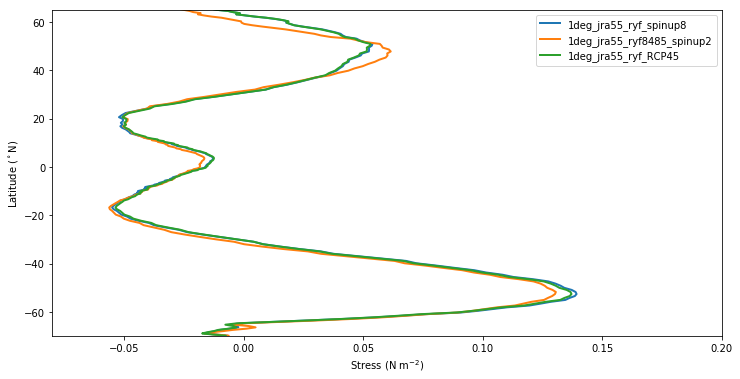

In [4]:
cc.plots.wind_stress(esub)

## Ocean Scalars
The following series of plots shows global timeseries of key metrics.

In [8]:
# If you want to clear stuff
#cc.diagnostics.annual_scalar.clear()

HBox(children=(IntProgress(value=0, description='variables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='experiments: ', max=3), HTML(value='')))

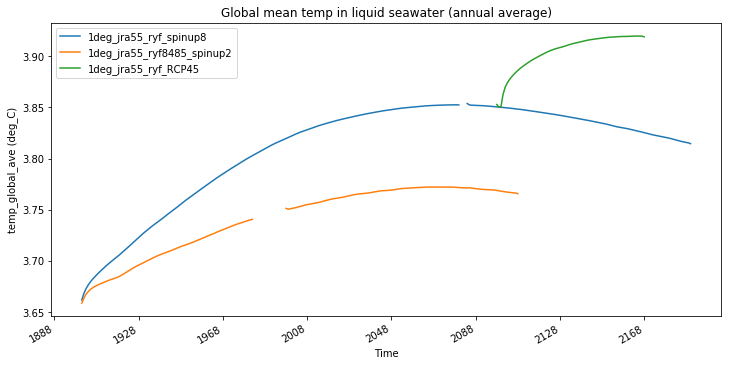

In [10]:
cc.plots.annual_scalar(esub, 'temp_global_ave')

HBox(children=(IntProgress(value=0, description='variables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='experiments: ', max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, description='get_nc_variable:: ', max=143), HTML(value='')))

HBox(children=(IntProgress(value=0, description='get_nc_variable:: ', max=192), HTML(value='')))

HBox(children=(IntProgress(value=0, description='get_nc_variable:: ', max=35), HTML(value='')))

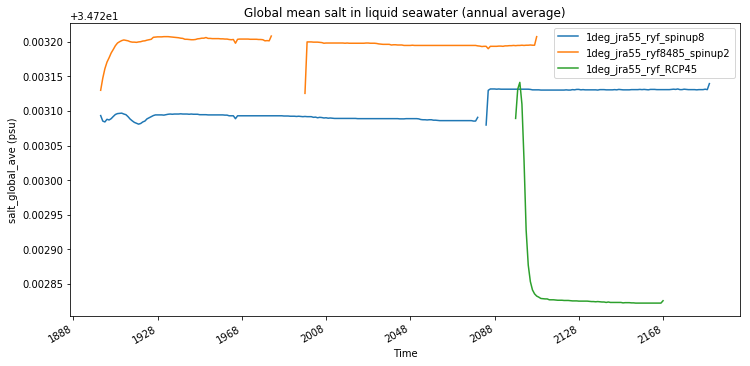

In [11]:
cc.plots.annual_scalar(esub, 'salt_global_ave')

HBox(children=(IntProgress(value=0, description='variables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='experiments: ', max=3), HTML(value='')))

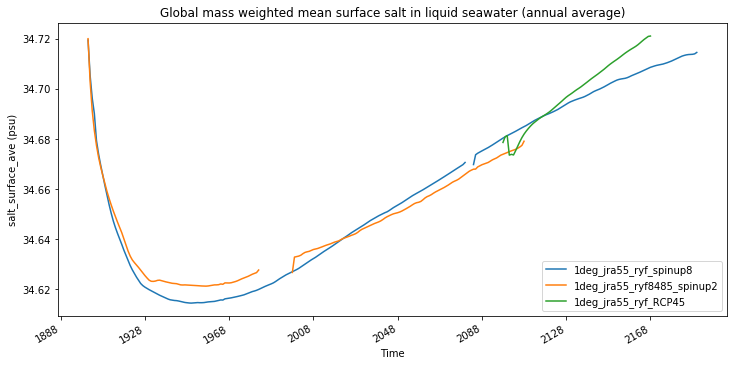

In [13]:
cc.plots.annual_scalar(esub, 'salt_surface_ave')

HBox(children=(IntProgress(value=0, description='variables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='experiments: ', max=3), HTML(value='')))

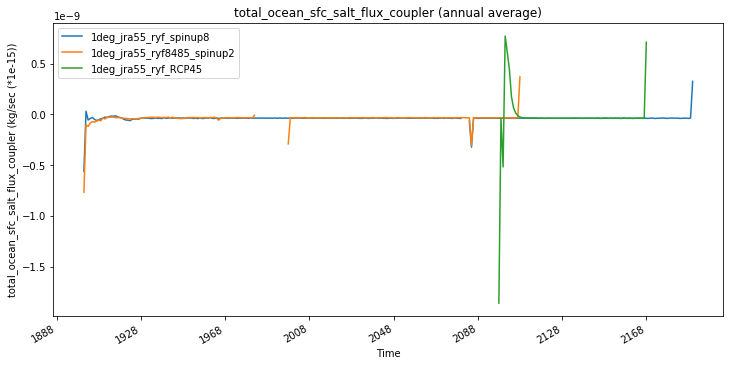

In [10]:
cc.plots.annual_scalar(esub, 'total_ocean_sfc_salt_flux_coupler')

HBox(children=(IntProgress(value=0, description='variables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='experiments: ', max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, description='get_nc_variable:: ', max=143), HTML(value='')))

HBox(children=(IntProgress(value=0, description='get_nc_variable:: ', max=192), HTML(value='')))

HBox(children=(IntProgress(value=0, description='get_nc_variable:: ', max=35), HTML(value='')))

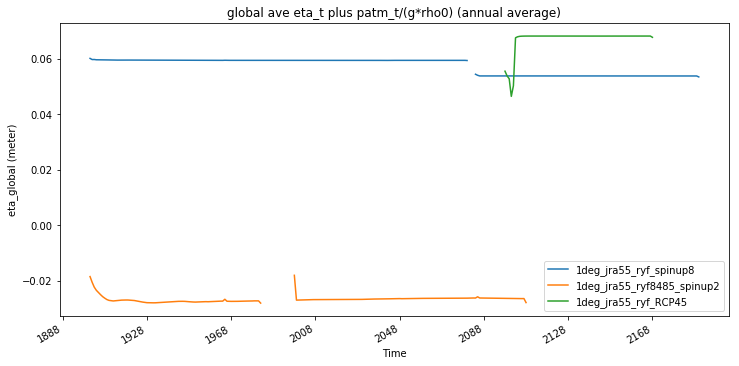

In [15]:
cc.plots.annual_scalar(esub, 'eta_global')

In [10]:
variables = cc.netcdf_index.get_scalar_variables(configuration)

In [11]:
from ipywidgets import widgets, interact, interactive, fixed
interactive(cc.plots.annual_scalar,
            expts=fixed(esub),
            variable=widgets.Dropdown(options=variables, description='Scalar Variable:'))

interactive(children=(Dropdown(description='variables', options=(), value=None), Output()), _dom_classes=('widget-interact',))

# Drake Passage Transport

HBox(children=(IntProgress(value=0, description='experiments: ', max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, description='get_nc_variable:: ', max=143), HTML(value='')))

HBox(children=(IntProgress(value=0, description='get_nc_variable:: ', max=192), HTML(value='')))

HBox(children=(IntProgress(value=0, description='get_nc_variable:: ', max=35), HTML(value='')))

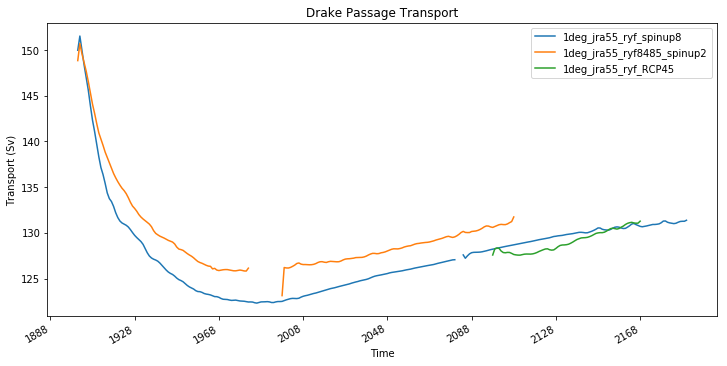

In [14]:
cc.plots.drake_passage(esub)

# Meridional Overturning Circulation

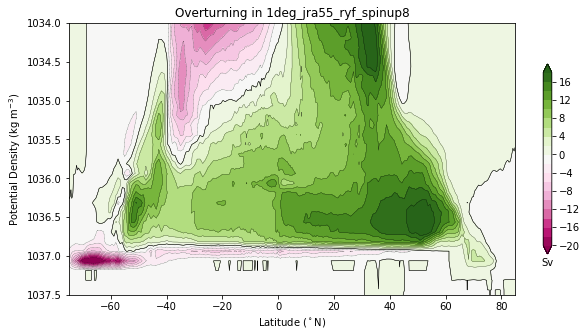

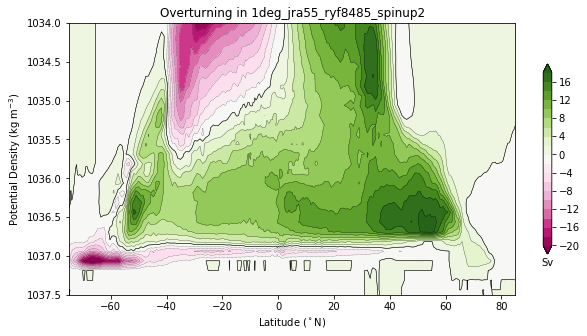

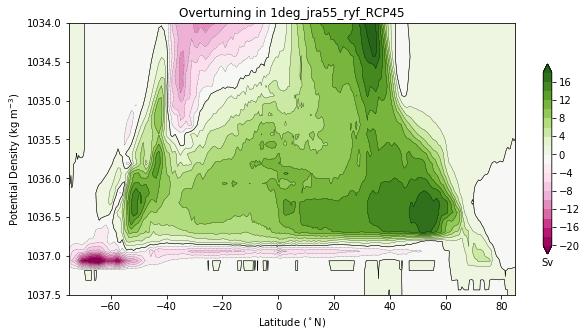

In [14]:
for e in esub: 
    cc.plots.psi_avg(e,10,GM=True)

In [25]:
def calc_psi_time(expt): # TODO: cache these results?
    print('Calculating {} timeseries of transport '.format(expt))
    
    #op = lambda p: p.sum('grid_xt_ocean').cumsum('potrho')

    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          #op=op,
                          chunks={'potrho': None},
                          time_units = 'days since 1900-01-01')
    
    if psi.units == 'kg/s':
        print('WARNING: Changing units for ', expt)
        psi = psi*1.0e-9
    
    psi_sum = psi.sum('grid_xt_ocean').cumsum('potrho')
    
    psi_aabw = psi_sum[:,60:,48].min('potrho').resample('3A',dim='time')
    psi_aabw = psi_aabw.compute()
    psi_amoc = psi_sum[:,60:,193].max('potrho').resample('3A',dim='time')
    psi_amoc = psi_amoc.compute()
    psi_amoc_south = psi_sum[:,60:,70].max('potrho').resample('3A',dim='time')
    psi_amoc_south = psi_amoc_south.compute()
    
    return psi_aabw, psi_amoc, psi_amoc_south

Calculating 1deg_jra55_ryf_spinup8 timeseries of transport 
Calculating 1deg_jra55_ryf8485_spinup2 timeseries of transport 
Calculating 1deg_jra55_ryf_RCP45 timeseries of transport 


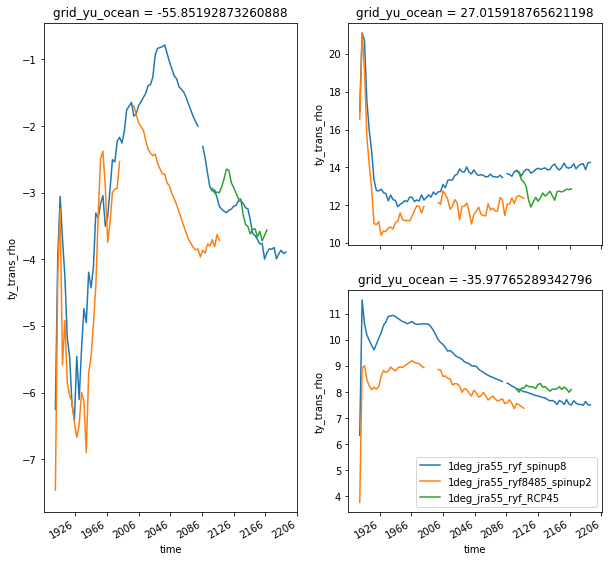

In [26]:
plt.figure(figsize=(10, 10)) 
for e in esub: 
    psi_aabw,psi_amoc,psi_amoc_south = calc_psi_time(e)
        
    plt.subplot(121)
    psi_aabw.plot()
    plt.subplot(222)
    psi_amoc.plot()
    plt.subplot(224)
    psi_amoc_south.plot(label=e)
    
plt.legend()

# Sea Surface Temperature
LH column shows SST, RH column shows difference from Year 1.

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


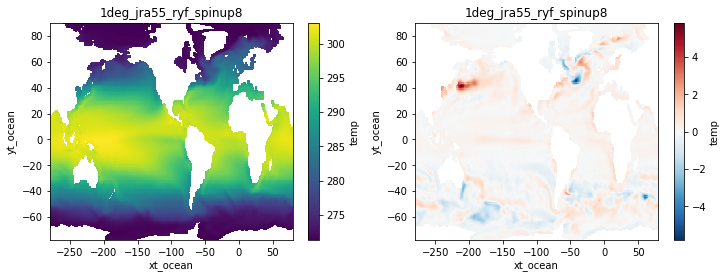

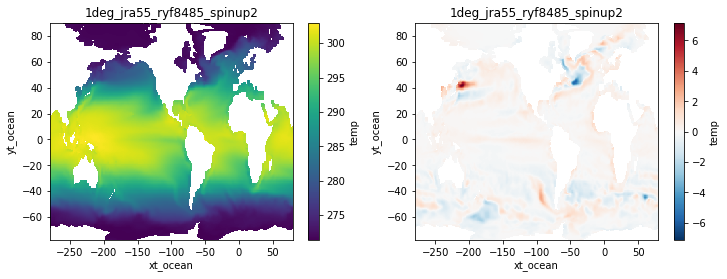

In [13]:
cc.plots.sea_surface_temperature(esub[:2])

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


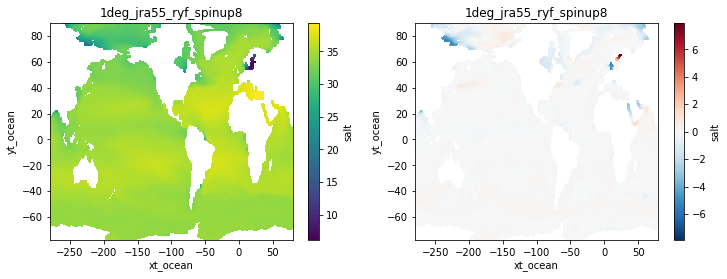

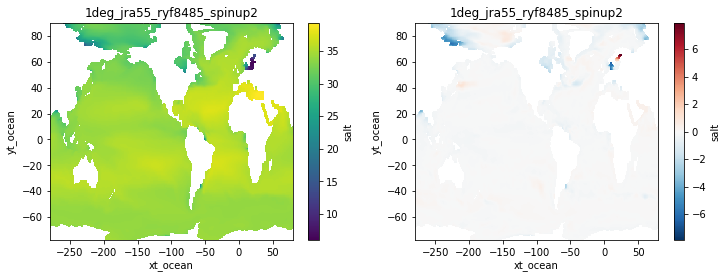

In [14]:
cc.plots.sea_surface_salinity(esub[:2])

# Zonal Mean transects

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


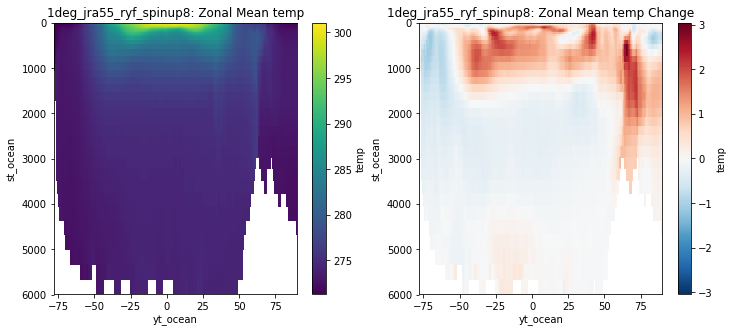

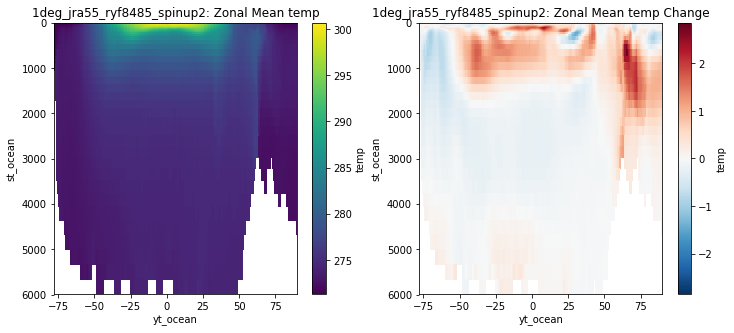

In [21]:
cc.plots.zonal_mean(esub[:2],'temp',n=10)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


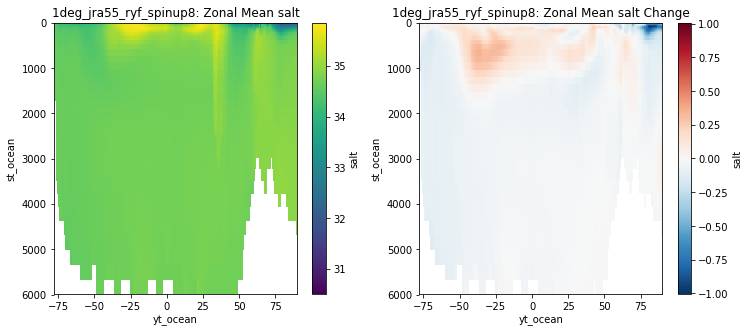

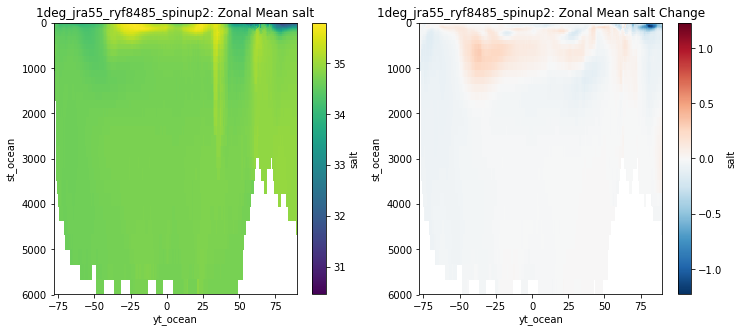

In [20]:
cc.plots.zonal_mean(esub[:2],'salt',n=10)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


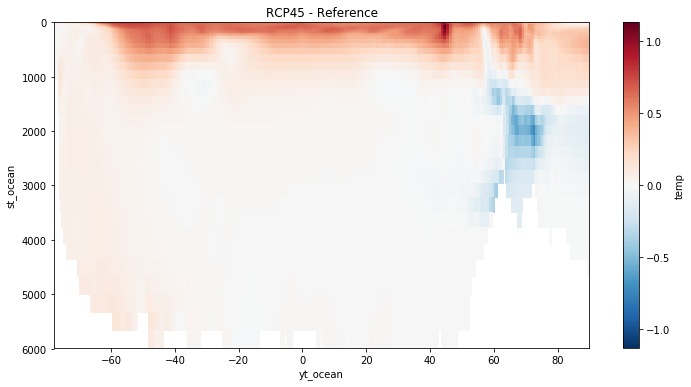

In [19]:
zonal_mean, zonal_diff = cc.diagnostics.zonal_mean(esub[0],'temp',n=10)
zonal_mean_new, zonal_diff = cc.diagnostics.zonal_mean(esub[2],'temp',n=10)

zonal_diff = zonal_mean_new - zonal_mean
plt.figure(figsize=(12,6))
zonal_diff.plot()
plt.title('RCP45 - Reference')
plt.gca().invert_yaxis()


/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


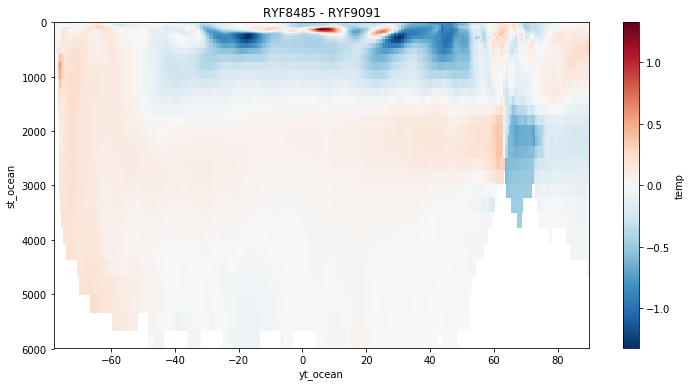

In [27]:
zonal_mean, zonal_diff = cc.diagnostics.zonal_mean(esub[0],'temp',n=10)
zonal_mean_new, zonal_diff = cc.diagnostics.zonal_mean(esub[1],'temp',n=10)

zonal_diff = zonal_mean_new - zonal_mean.values
plt.figure(figsize=(12,6))
zonal_diff.plot()
plt.title('RYF8485 - RYF9091')
plt.gca().invert_yaxis()

In [25]:
zonal_mean_new

<xarray.DataArray 'temp' (st_ocean: 50, yt_ocean: 300)>
dask.array<mean_agg-aggregate, shape=(50, 300), dtype=float64, chunksize=(50, 150)>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 -77.13 -76.88 -76.63 ...
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 35.0 45.0 55.0 65.0 75.0 85.0 ...